##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

/home/coder/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-30 09:47:50.598713: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 09:47:50.645324: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 09:47:50.646810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 09:47:51.371055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric): # history = performance during training
  plt.plot(history.history[metric]) # plot metric value for each point in history
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load(
    'imdb_reviews', 
    with_info = True,
    as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

2023-03-30 09:50:23.800799: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dataset imdb_reviews downloaded and prepared to /home/coder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print(
    'text: ', 
    example.numpy())
  print(
    'label: ', 
    label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2023-03-30 09:51:21.059591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-03-30 09:51:21.060214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-03-30 09:51:21.126166: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
# The data contains 25000 data points. From this we randomly draw a 
# buffer pool of 10000. Then from this we randomly draw a batch of 64 
# to train the model. Buffer and batch represent a tradeoff between 
# memory and performance for the computer. Using a small buffer means 
# the computer has to shuffle less data at any given point in time 
# (since it is this buffer that the batches have to randomly be drawn
# from, which in the case of a large buffer can be very computationally
# expensive), but having a too small buffer means that you are essenti-
# ally reshuffling the same small pool of data and you will experience
# drastic drops in performance after a few goes.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

2023-03-30 10:02:23.864036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-03-30 10:02:23.864752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


texts:  [b'1914 was an amazing year for Charlie Chaplin. It was his first year in films and he appeared in more than 30 films! While most of these films weren\'t particularly good, they did give him a chance to slowly evolve his screen persona. However, by this film, the familiar "Little Tramp" character was still in development. Sure Charlie looked the part, but his character still lacked the sweetness and decency that he later developed. Instead, Chaplin often hit, kicked or did other nasty things to people for seemingly no reason at all.<br /><br />As for this very slight film, it is interesting to watch for the cast. While they are not familiar today, Chaplin stars along with Mabel Normand, Chester Conklin and Mack Swain--all exceptionally popular stars with Keystone Films. The problem with this film is that while it has a few nice scenes, the plot seems very vague and improperly developed. Chester and Mabel got to the race track (a very common theme in Keystone productions--it mus

2023-03-30 10:02:24.216678: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000 # only 1000 most frequent words; 
# to each word a unique int value 0-1000 is assigned for indexing
encoder = tf.keras.layers.TextVectorization(
    max_tokens = VOCAB_SIZE)
encoder.adapt( # analyzes the dataset and creates a vocabulary from it
    train_dataset.map(
        lambda text, 
        label: text))

2023-03-30 10:49:07.907510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-03-30 10:49:07.907949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [17]:
encoded_example = encoder(example)[:3].numpy()
encoded_example
# The words that are not part of the 1000 most common words are removed.
# The words that stayed are in order. The length of the vector is the
# length of the longest document; for shorter documents, the end of the
# vector is padded with 0s.

array([[  1,  14,  34, ...,   0,   0,   0],
       [  8,  29,   5, ...,   0,   0,   0],
       [994, 154,   1, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [18]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'1914 was an amazing year for Charlie Chaplin. It was his first year in films and he appeared in more than 30 films! While most of these films weren\'t particularly good, they did give him a chance to slowly evolve his screen persona. However, by this film, the familiar "Little Tramp" character was still in development. Sure Charlie looked the part, but his character still lacked the sweetness and decency that he later developed. Instead, Chaplin often hit, kicked or did other nasty things to people for seemingly no reason at all.<br /><br />As for this very slight film, it is interesting to watch for the cast. While they are not familiar today, Chaplin stars along with Mabel Normand, Chester Conklin and Mack Swain--all exceptionally popular stars with Keystone Films. The problem with this film is that while it has a few nice scenes, the plot seems very vague and improperly developed. Chester and Mabel got to the race track (a very common theme in Keystone productions--it m

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(
            encoder.get_vocabulary()),
        output_dim = 64,
        # Use masking to handle the variable sequence lengths
        mask_zero = True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            64)),
    tf.keras.layers.Dense(
        64, 
        activation = 'relu'),
    tf.keras.layers.Dense(
        1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [20]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [21]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(
    np.array([
        sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.00671053]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [22]:
# predict on a sample text with padding
# padding = we just add random words (fx in order to make text of same length)
padding = "the " * 2000
predictions = model.predict(
    np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 234ms/step
[-0.00671053]


Compile the Keras model to configure the training process:

In [23]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits = True),
        optimizer = tf.keras.optimizers.Adam(
            1e-4),
            metrics=['accuracy'])

## Train the model

In [24]:
history = model.fit(
    train_dataset, 
    epochs = 10,
    validation_data = test_dataset,
    validation_steps = 30)

Epoch 1/10


2023-03-30 11:07:26.580220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-03-30 11:07:26.580855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-03-30 11:07:28.560822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with 

391/391 [==============================] - ETA: 0s - loss: 0.6193 - accuracy: 0.6015

2023-03-30 11:11:15.852606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-03-30 11:11:15.853049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


391/391 [==============================] - 236s 591ms/step - loss: 0.6193 - accuracy: 0.6015 - val_loss: 0.4644 - val_accuracy: 0.7615
Epoch 2/10


2023-03-30 11:11:22.906045: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 227s 581ms/step - loss: 0.3894 - accuracy: 0.8224 - val_loss: 0.3614 - val_accuracy: 0.8292
Epoch 3/10


2023-03-30 11:15:10.315282: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 226s 579ms/step - loss: 0.3384 - accuracy: 0.8518 - val_loss: 0.3393 - val_accuracy: 0.8458
Epoch 4/10


2023-03-30 11:18:56.801064: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 227s 581ms/step - loss: 0.3188 - accuracy: 0.8620 - val_loss: 0.3400 - val_accuracy: 0.8562
Epoch 5/10


2023-03-30 11:22:44.219487: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 227s 581ms/step - loss: 0.3135 - accuracy: 0.8640 - val_loss: 0.3306 - val_accuracy: 0.8521
Epoch 6/10


2023-03-30 11:26:31.363986: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 224s 572ms/step - loss: 0.3082 - accuracy: 0.8654 - val_loss: 0.3465 - val_accuracy: 0.8573
Epoch 7/10


2023-03-30 11:30:15.122196: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 222s 568ms/step - loss: 0.3060 - accuracy: 0.8678 - val_loss: 0.3372 - val_accuracy: 0.8562
Epoch 8/10


2023-03-30 11:33:57.494036: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 223s 571ms/step - loss: 0.3046 - accuracy: 0.8685 - val_loss: 0.3341 - val_accuracy: 0.8594
Epoch 9/10


2023-03-30 11:37:40.918019: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 224s 571ms/step - loss: 0.3014 - accuracy: 0.8700 - val_loss: 0.3309 - val_accuracy: 0.8594
Epoch 10/10


2023-03-30 11:41:24.503900: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 222s 568ms/step - loss: 0.2988 - accuracy: 0.8710 - val_loss: 0.3182 - val_accuracy: 0.8589


2023-03-30 11:45:06.712536: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [25]:
test_loss, test_acc = model.evaluate(
    test_dataset)

print(
    'Test Loss:', test_loss)
print(
    'Test Accuracy:', test_acc)

391/391 [==============================] - 67s 172ms/step - loss: 0.3143 - accuracy: 0.8608
Test Loss: 0.314324289560318
Test Accuracy: 0.8608400225639343


(0.0, 0.6353309348225593)

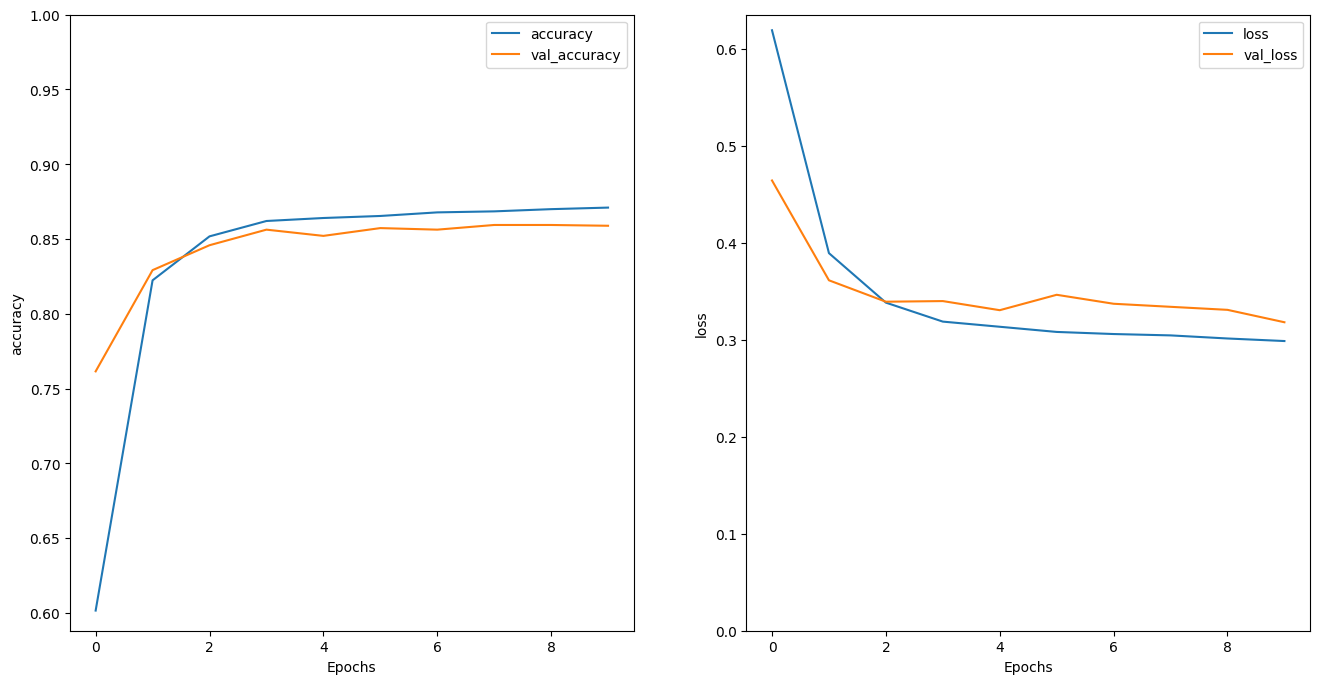

In [26]:
plt.figure(
    figsize = (16, 8))
plt.subplot(
    1, 2, 1)
plot_graphs(
    history, 
    'accuracy')
plt.ylim(
    None, 1)
plt.subplot(
    1, 2, 2)
plot_graphs(
    history, 
    'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [28]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(
    np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 30ms/step
[[0.7880422]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [29]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        len(encoder.get_vocabulary()), 
        64, 
        mask_zero = True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            64, 
            return_sequences = True)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            32)),
    tf.keras.layers.Dense(
        64, 
        activation = 'relu'),
    tf.keras.layers.Dropout(
        0.5),
    tf.keras.layers.Dense(
        1)
])

In [30]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits = True),
        optimizer=tf.keras.optimizers.Adam(
            1e-4),
            metrics=['accuracy'])

In [31]:
history = model.fit(
    train_dataset, 
    epochs = 10,
    validation_data = test_dataset,
    validation_steps = 30)

Epoch 1/10


2023-03-30 11:55:22.342033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 11:55:22.886694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 11:55:26.661199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

391/391 [==============================] - 433s 1s/step - loss: 0.6280 - accuracy: 0.5784 - val_loss: 0.4520 - val_accuracy: 0.7406
Epoch 2/10
391/391 [==============================] - 412s 1s/step - loss: 0.3942 - accuracy: 0.8289 - val_loss: 0.3661 - val_accuracy: 0.8286
Epoch 3/10
391/391 [==============================] - 407s 1s/step - loss: 0.3444 - accuracy: 0.8532 - val_loss: 0.3462 - val_accuracy: 0.8344
Epoch 4/10
391/391 [==============================] - 412s 1s/step - loss: 0.3282 - accuracy: 0.8606 - val_loss: 0.3295 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 419s 1s/step - loss: 0.3158 - accuracy: 0.8659 - val_loss: 0.3402 - val_accuracy: 0.8344
Epoch 6/10
391/391 [==============================] - 410s 1s/step - loss: 0.3106 - accuracy: 0.8687 - val_loss: 0.3282 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 415s 1s/step - loss: 0.3054 - accuracy: 0.8693 - val_loss: 0.3234 - val_accuracy: 0.8500
Epoch 8/10

In [32]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 113s 289ms/step - loss: 0.3136 - accuracy: 0.8578
Test Loss: 0.313582181930542
Test Accuracy: 0.8578000068664551


In [33]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 3s 3s/step
[[-1.9099722]]


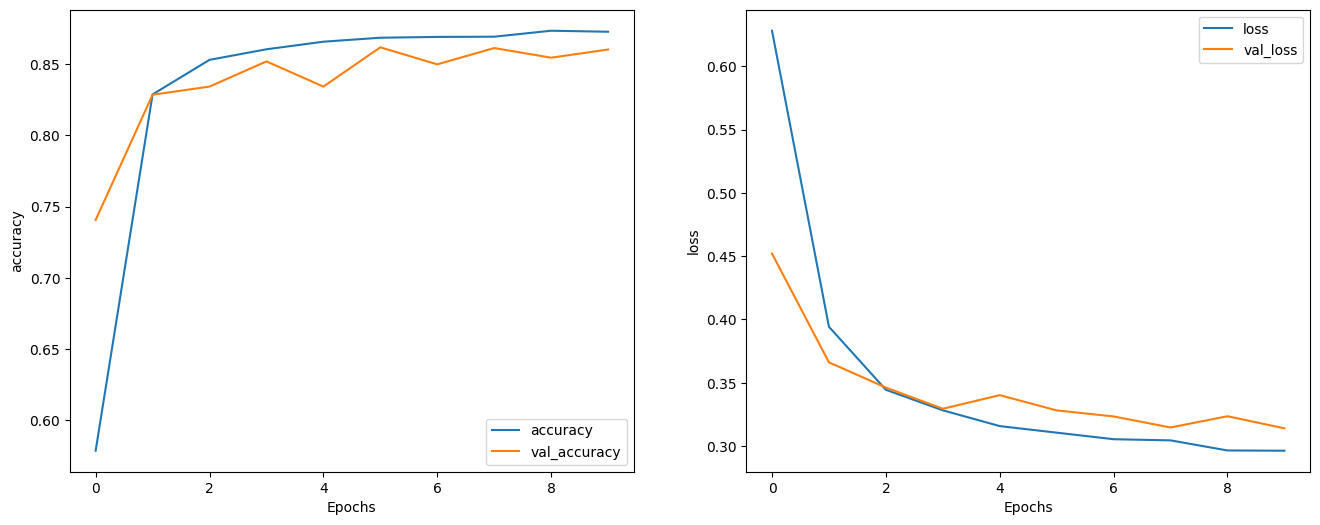

In [34]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
